# JC chain device simulation

* In this notebook we will do some simulations for the Jaines-Cummings chain for system sizes attainable in lab $(L\sim 10)$

* We will look at the $XX$ and $ZZ$ correaltion functions and entanglement entropy for various choices of the time parameter $\theta$


In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

import scipy as sp
from scipy import linalg

from JC_functions import *

## Lets look at the hopping probabilities for 8 different values of $\theta$ 

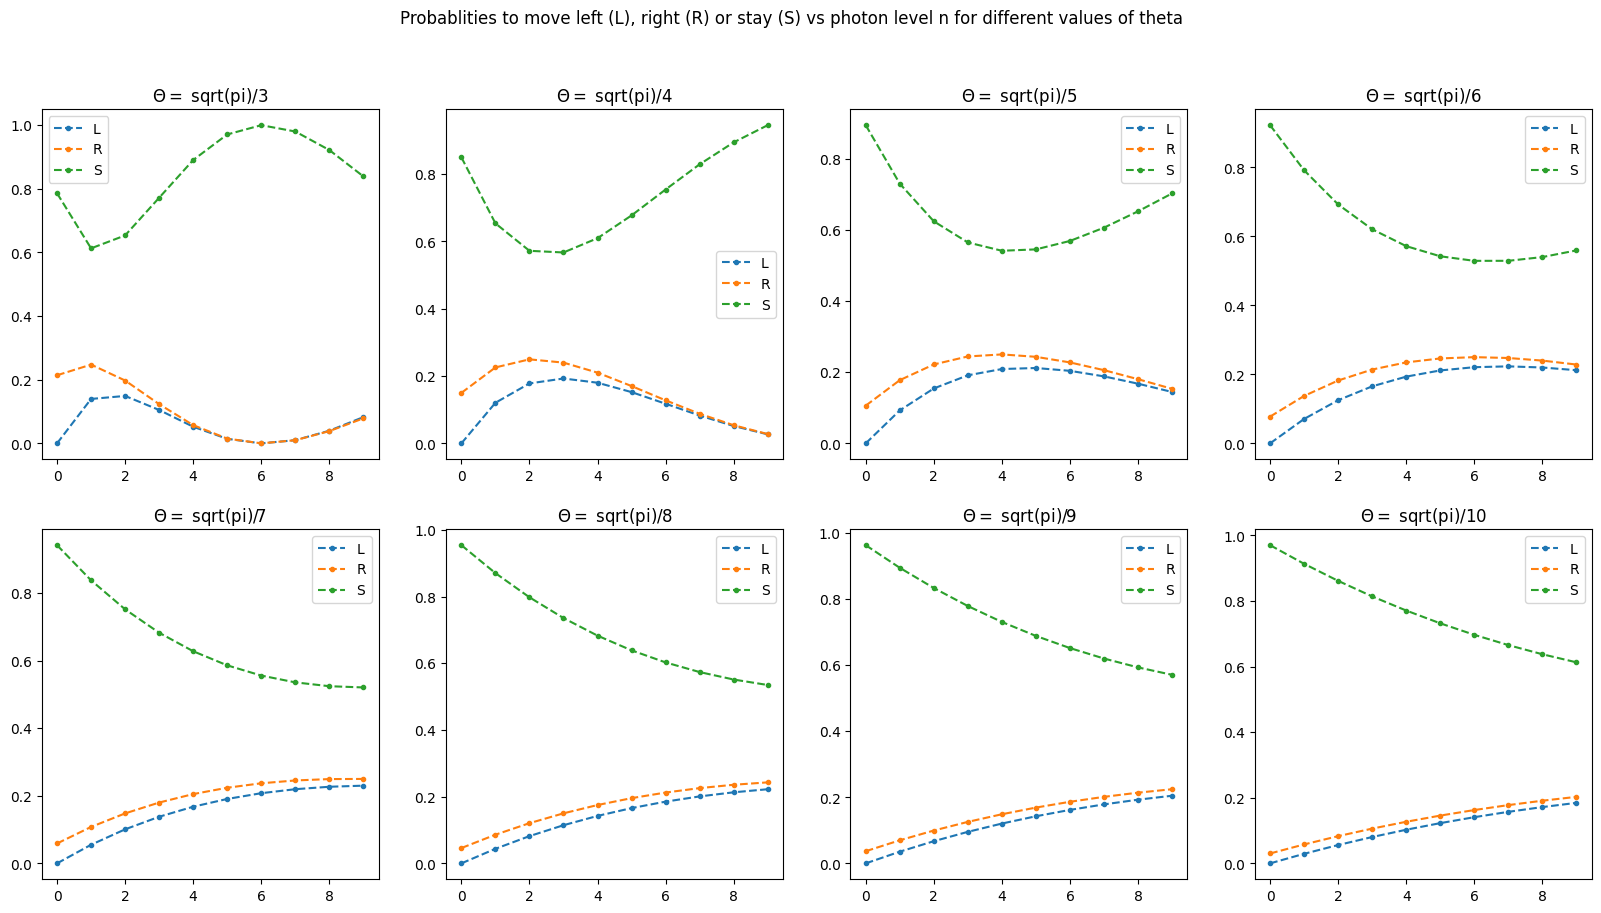

In [2]:
N= 10
theta_list = [np.sqrt(np.pi)/i for i in range(3,12)]
theta_sym_list = [sym.symbols(f'{sym.sqrt(sym.pi)/i}') for i in range(3,12)]


fig, axs = plt.subplots(2,4, figsize = (20,10))
for i in range(4):
    for j in range(2):
        L, S, R = [[], [],[]]
        for n in range(N):
            P = Hop_prob(n,theta_list[4*j + i])
            L.append(P[0])
            S.append(P[1])
            R.append(P[2])

        axs[j,i].plot(L, '--.', label = 'L')
        axs[j,i].plot(R, '--.', label = 'R')
        axs[j,i].plot(S, '--.', label = 'S')
        axs[j,i].set_title(f'$\Theta =$ {theta_sym_list[4*j+i]}')
        axs[j,i].legend()

fig.suptitle('Probablities to move left (L), right (R) or stay (S) vs photon level n for different values of theta')
plt.show()


# Now lets define some matrix product states:

## MPS for the choice of $\theta$ above

In [3]:
MPS_dictionary_theta = {}
chi = int(N/2)

for theta in theta_list:
    A_JC = MPS_JC_2site(chi,theta)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list = [A_JC for i in range(N)]
    MPS_list.insert(0, BL)
    MPS_list.append(BL)

    JC_MPS = MatrixProductState(MPS_list, shape = 'plr')
    JC_MPS.cyclic = False
    JC_MPS.normalize()

    MPS_dictionary_theta[theta] = JC_MPS

## MPS for Motzkin chain (for comparison)

In [4]:
pL, pR = [.2,.2]
A_Motz = MPS_Motzkin(chi, pL,pR)
BL = np.zeros((2, chi, chi))
BL[0,0,0] = 1

MPS_list1 = [A_Motz for i in range(N)]
MPS_list1.insert(0, BL)
MPS_list1.append(BL)

Motz_MPS = MatrixProductState(MPS_list1, shape = 'plr')
Motz_MPS.cyclic = False
Motz_MPS.normalize()


0.19833640960000012

# Now lets plot correlation functions for the MPS above

In [5]:
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]

Zspin1 = pauli('Z', dim=3)
Xspin1 = pauli('X', dim=3)


## ZZ and XX correlation function matrix for each theta:

In [6]:
ZZ_data_JC, XX_data_JC = [{}, {}]
ZZ_data_motz, XX_data_motz = [np.zeros((N,N)), np.zeros((N,N))]

x_by_y = [[x+1,y+1] for x in range(N-1) for y in range(N-1)]

for theta in theta_list:
    ZZ, XX = [np.zeros((N,N)), np.zeros((N,N))]
    for r in x_by_y:
        ZZ[r[0],r[1]] = np.real(MPS_dictionary_theta[theta].correlation(Z_A+Z_B, r[0], r[1]))
        XX[r[0],r[1]] = np.real(MPS_dictionary_theta[theta].correlation(X_A+X_B, r[0], r[1]))

    ZZ_data_JC[theta] = ZZ
    XX_data_JC[theta] = XX

for r in x_by_y:
    ZZ_data_motz[r[0],r[1]] = np.real(Motz_MPS.correlation(Zspin1, r[0], r[1]))
    XX_data_motz[r[0],r[1]] = np.real(Motz_MPS.correlation(Xspin1, r[0], r[1]))

## Grid of XX and ZZ correlation functions 


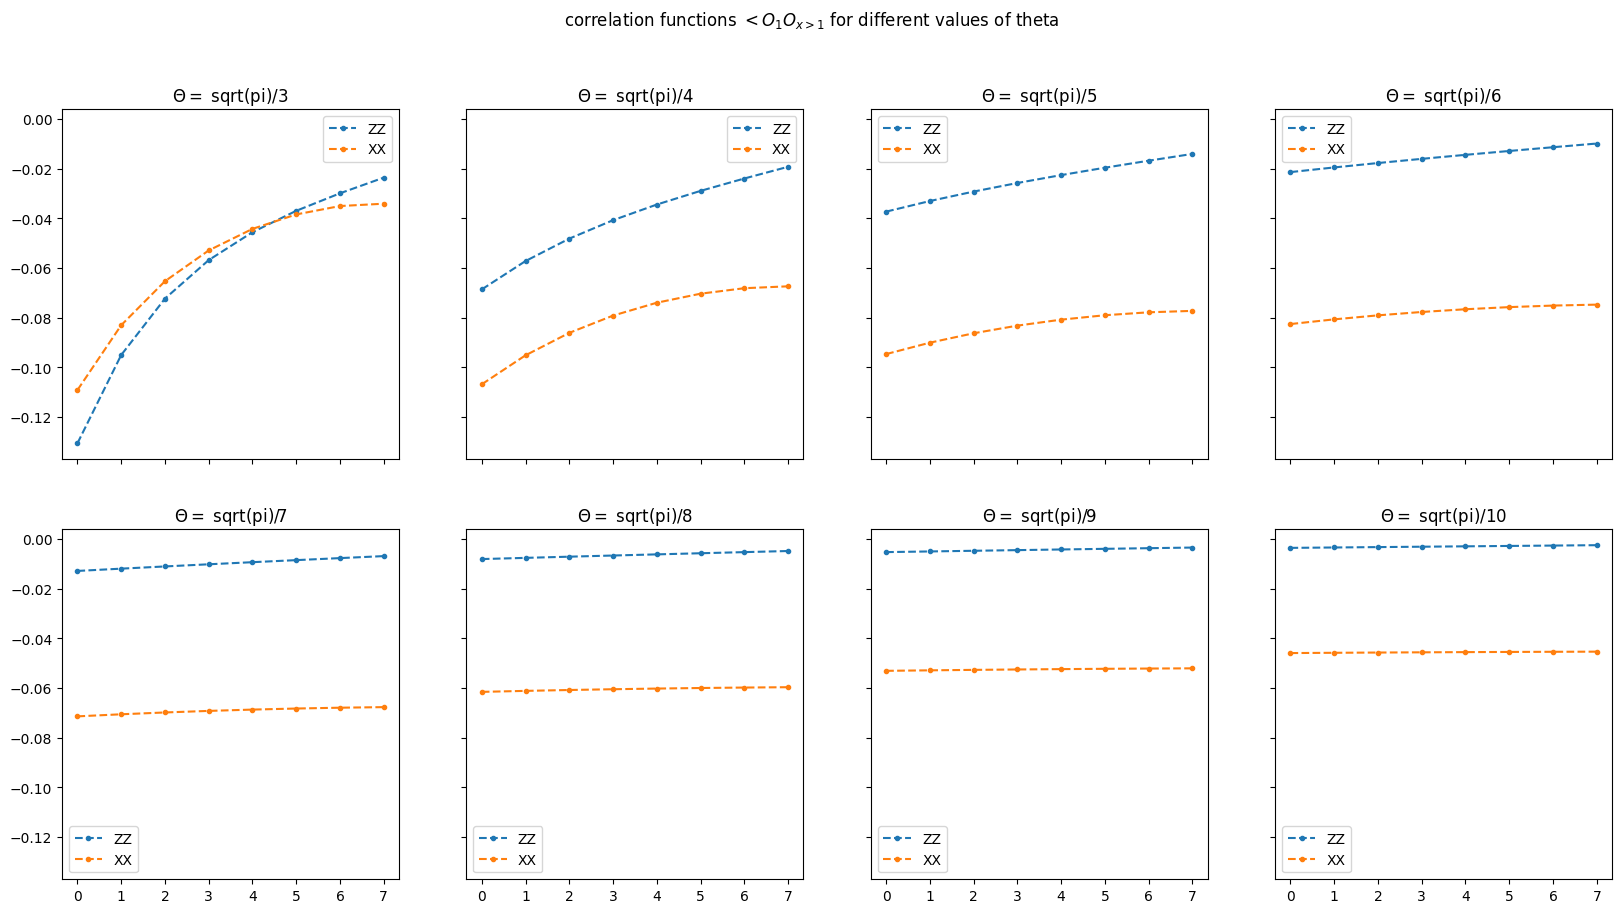

In [7]:
fig, axs = plt.subplots(2,4, figsize = (20,10), sharex=True, sharey=True)
for x in range(4):
    for y in range(2):
        axs[y,x].plot(ZZ_data_JC[theta_list[4*y+x]][1,2:], '.--', label = 'ZZ')
        axs[y,x].plot(XX_data_JC[theta_list[4*y+x]][1,2:], '.--', label = 'XX')
        #axs[y,x].plot(ZZ_data_motz[1,2:], '.--', label = 'ZZ motz')
        #axs[y,x].plot(XX_data_motz[1,2:], '.--', label = 'XX motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[4*y+x]}')
        axs[y,x].legend()


fig.suptitle('correlation functions $<O_1 O_{x>1}$ for different values of theta')
plt.show()

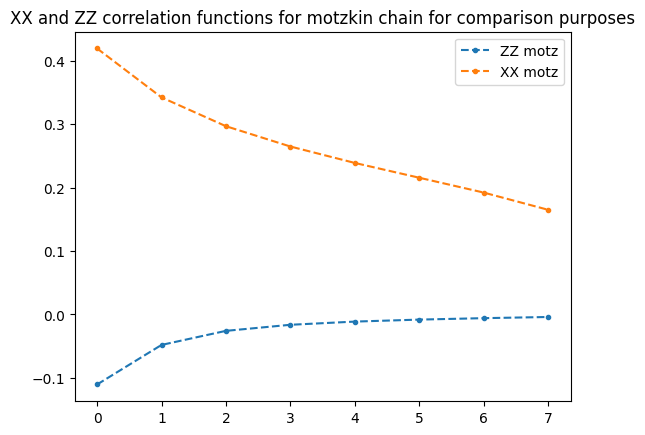

In [8]:
plt.plot(ZZ_data_motz[1,2:], '.--', label = 'ZZ motz')
plt.plot(XX_data_motz[1,2:], '.--', label = 'XX motz')
plt.legend()
plt.title('XX and ZZ correlation functions for motzkin chain for comparison purposes')
plt.show()

# $S_E$ array for each theta

In [9]:
SE_data_JC = {}
for theta in theta_list:
    SE_array = np.zeros(N)
    for x in range(N):
        SE_array[x] = MPS_dictionary_theta[theta].entropy(x+1)

    SE_data_JC[theta] = SE_array

SE_motz = np.zeros(N)
for x in range(N):
    SE_motz[x] = Motz_MPS.entropy(x+1)

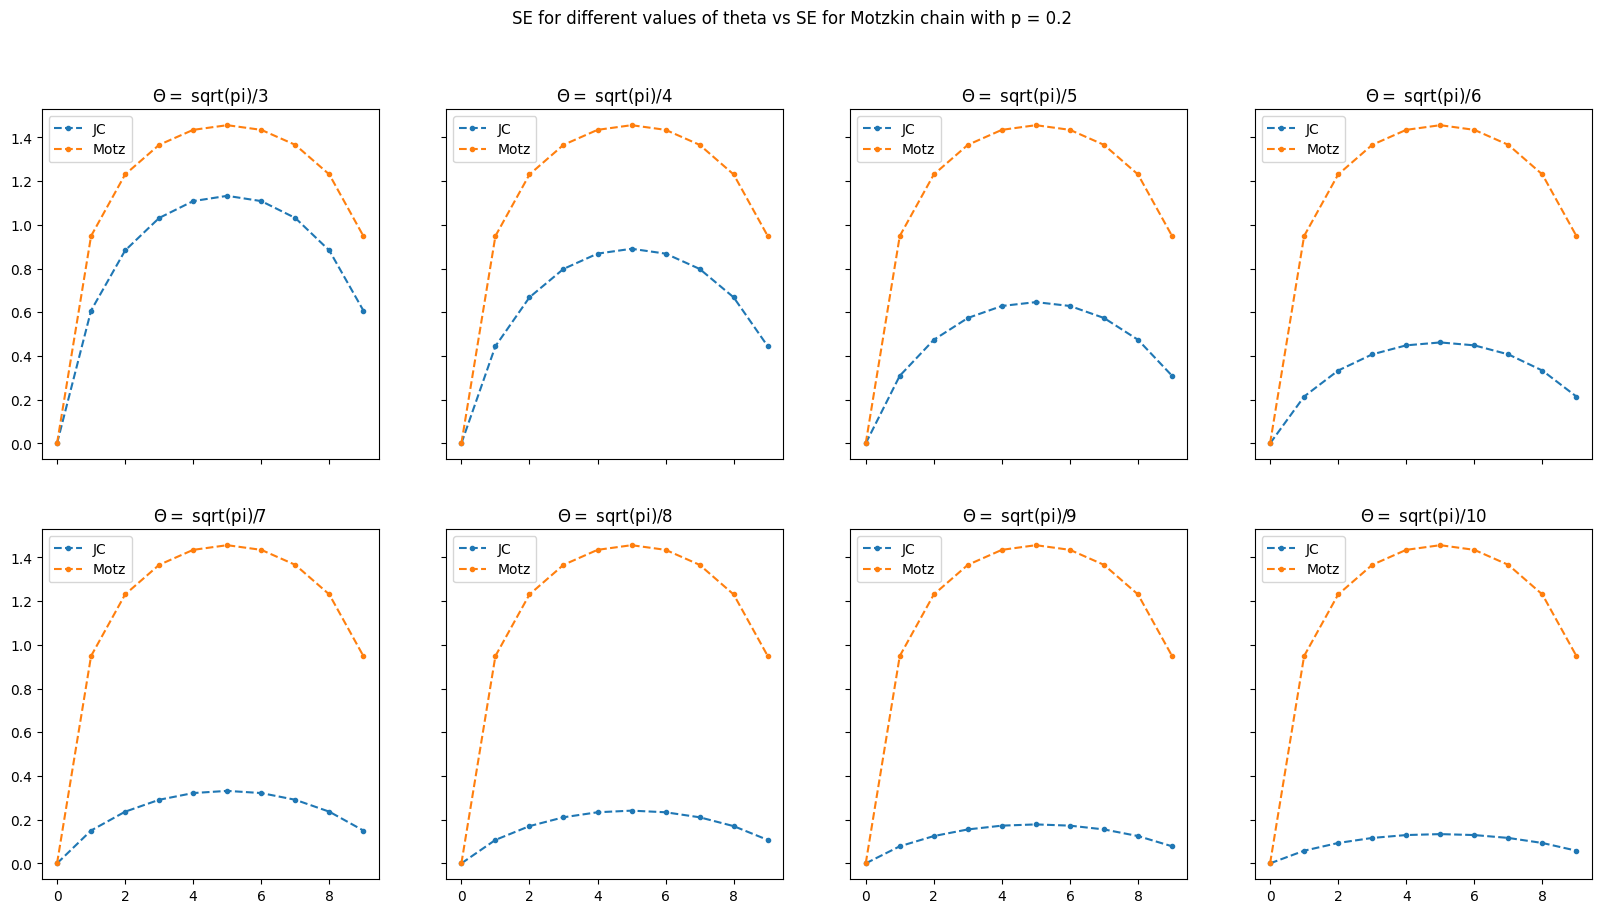

In [10]:
fig, axs = plt.subplots(2,4, figsize = (20,10), sharex=True, sharey=True)
for x in range(4):
    for y in range(2):
        axs[y,x].plot(SE_data_JC[theta_list[4*y+x]], '.--', label = 'JC')
        axs[y,x].plot(SE_motz, '.--', label = 'Motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[4*y+x]}')
        axs[y,x].legend()


fig.suptitle(f'SE for different values of theta vs SE for Motzkin chain with p = {pL}')
plt.show()